In [1]:
# import libraries
import argparse, os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from imwatermark import WatermarkEncoder


from scripts.txt2img import put_watermark
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

/fs/nexus-scratch/mrislam/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_lightning import seed_everything

In [3]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    #w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    w, h = 768, 768
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

In [4]:
seed_everything(42) # using seed 42

Global seed set to 42


42

In [5]:
from ldm.modules.diffusionmodules.model import Downsample, Upsample
intermediate_outputs = {}

def hook_fn(module, input, output):
    layer_name = module.__class__.__name__
    if layer_name not in intermediate_outputs:
        intermediate_outputs[layer_name] = []
    intermediate_outputs[layer_name].append(output)

No module 'xformers'. Proceeding without it.


In [6]:
import torchvision.transforms as T

In [7]:
transform = T.ToPILImage()

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
config = OmegaConf.load("../configs/stable-diffusion/v2-inference-v.yaml") 
model = load_model_from_config(config, "/fs/nexus-scratch/mrislam/v2-1_768-nonema-pruned.ckpt") # add , device?
# move to GPU 
model = model.to(device)

Loading model from /fs/nexus-scratch/mrislam/v2-1_768-nonema-pruned.ckpt
Global Step: 110000
LatentDiffusion: Running in v-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [10]:
for name, layer in model.named_modules():
    if isinstance(layer, (Downsample, Upsample)):  # Specify the types of layers you are interested in
        layer.register_forward_hook(hook_fn)

In [11]:
init_img = load_img("../assets/test3.png").to(device)
init_img.shape

loaded input image of size (512, 512) from ../assets/test3.png


torch.Size([1, 3, 768, 768])

In [12]:
intermediate_outputs.clear()

In [13]:
latent = model.get_first_stage_encoding(model.encode_first_stage(init_img))
latent.shape

torch.Size([1, 4, 96, 96])

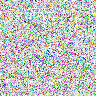

In [14]:
transform(latent[0])

In [15]:
# sampler = DDIMSampler(model, device="cuda") # change to device?
# sampler

In [20]:
from ldm.models.diffusion.dpm_solver import DPMSolverSampler
sampler = DDIMSampler(model, device="cuda") # change to device?
sampler

In [27]:
steps = 100

In [28]:
sampler.make_schedule(ddim_num_steps=steps, ddim_eta=0.0, verbose=False) # eta = 0.0 -> deterministic

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
gs = 7.0

In [31]:
imgs = {}
s, e = 30, 30
with torch.no_grad():
        with torch.autocast("cuda"), model.ema_scope():
            for t_enc in range(s, e + 10, 10):
                z_enc = sampler.stochastic_encode(latent, torch.tensor([t_enc]).to(device))
                uc = model.get_learned_conditioning([""])
                c = model.get_learned_conditioning(["A tire rolling."])
                samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=gs,
                                                     unconditional_conditioning=uc)
                x_samples = model.decode_first_stage(samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
                for x_sample in x_samples:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    imgs[t_enc] = Image.fromarray(x_sample.astype(np.uint8))
                # samples = sampler.decode(enc, c, t_enc, unconditional_guidance_scale=guidance_scale,
                #                                      unconditional_conditioning=uc, )
samples.shape

Running DDIM Sampling with 30 timesteps


Decoding image: 100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


torch.Size([1, 4, 96, 96])

In [23]:
for t_enc in range(10, 100, 10):
    imgs[t_enc].save(f"outputs/editing_exp/g{gs}_s{steps}_{t_enc}.png")

KeyError: 10

In [ ]:
imgs

In [ ]:
results.shape

In [ ]:
results = torch.clamp((results + 1.0) / 2.0, min=0.0, max=1.0)
# results = torch.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)
results = 255. * rearrange(results[0].cpu().numpy(), 'c h w -> h w c')
transform(results[0])

In [ ]:
for layer_name, outputs in intermediate_outputs.items():
    print(f"Layer: {layer_name}")
    for i, output in enumerate(outputs):
        print(f"  Output {i+1}: {output.shape}")

In [ ]:
from math import ceil

In [ ]:
grid_size = (10, 10)
grid_image = Image.new('RGB', (grid_size[0] * 64, ceil(len(intermediate_outputs["Downsample"][0][0])/grid_size[0]) * 64))
for idx, output in enumerate(intermediate_outputs["Downsample"][0][0]):
    image = transform(output).resize((64, 64), Image.LANCZOS)
    x = idx % grid_size[0] * 64
    y = idx // grid_size[0] * 64
    grid_image.paste(image, (x, y))
grid_image

In [ ]:
grid_size = (10, 10)
grid_image = Image.new('RGB', (grid_size[0] * 64, ceil(len(intermediate_outputs["Upsample"][2][0])/grid_size[0]) * 64))
for idx, output in enumerate(intermediate_outputs["Upsample"][2][0]):
    image = transform(output).resize((64, 64), Image.LANCZOS)
    x = idx % grid_size[0] * 64
    y = idx // grid_size[0] * 64
    grid_image.paste(image, (x, y))
grid_image

In [ ]:
transform(intermediate_outputs["Upsample"][2][0][10 * 6])

In [ ]:
transform(intermediate_outputs["Downsample"][1][0][10 * 6])

In [ ]:
transform(intermediate_outputs["Downsample"][0][0][10 * 6 + 1])

In [ ]:
res = model.first_stage_model()
res.shape

In [ ]:
# with torch.no_grad():
#         with torch.autocast("cuda"), model.ema_scope():
#             uc = model.get_learned_conditioning([""])
#             print(uc)
#             c = model.get_learned_conditioning(["A dog running."])
#             print(uc.shape, c.shape)
#             samples_ddim, _ = sampler.sample(S=100,
#                                              conditioning=c,
#                                              batch_size=1,
#                                              shape=[4, 768 // 8, 768 // 8],
#                                              verbose=True,
#                                              unconditional_guidance_scale=9.0,
#                                              unconditional_conditioning=uc,
#                                              eta=0.0,
#                                              x_T=None)
#             xs = model.decode_first_stage(samples_ddim)
#             xs = torch.clamp((xs + 1.0) / 2.0, min=0.0, max=1.0)
#             img = 255. * rearrange(xs[0].cpu().numpy(), 'c h w -> h w c')